# KNN - K Nearest Neighbors - Classification

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

gene expression: https://www.sciencedirect.com/topics/biochemistry-genetics-and-molecular-biology/gene-expression-level

In [3]:
df = pd.read_csv('../Data/gene_expression.csv')

In [4]:
df.head()

,Gene One,Gene Two,Cancer Present
0,4.3,3.9,1
1,2.5,6.3,0
2,5.7,3.9,1
3,6.1,6.2,0
4,7.4,3.4,1


# Data Exploration

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Gene One        3000 non-null   float64
 1   Gene Two        3000 non-null   float64
 2   Cancer Present  3000 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 70.4 KB


In [6]:
df.describe()

,Gene One,Gene Two,Cancer Present
count,3000.000000,3000.000000,3000.000000
mean,5.600133,5.410467,0.500000
std,1.828388,1.729081,0.500083
min,1.000000,1.000000,0.000000
25%,4.300000,4.000000,0.000000
50%,5.600000,5.400000,0.500000
75%,6.900000,6.700000,1.000000
max,10.000000,10.000000,1.000000


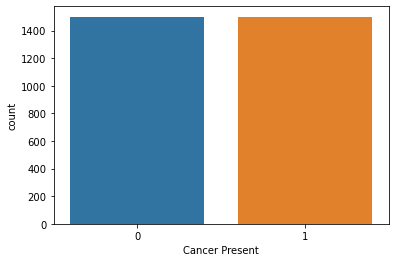

In [8]:
sns.countplot(data=df, x='Cancer Present');

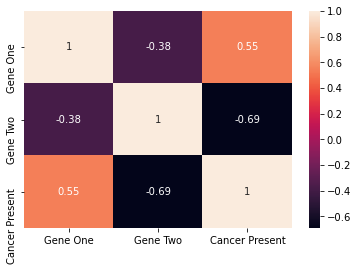

In [10]:
sns.heatmap(df.corr(), annot=True);

From the chart above, we can see that there is
- a positive correlation with Gene One and Cancer Present
- and a negative corrleation with Gene Two and Cancer Present.

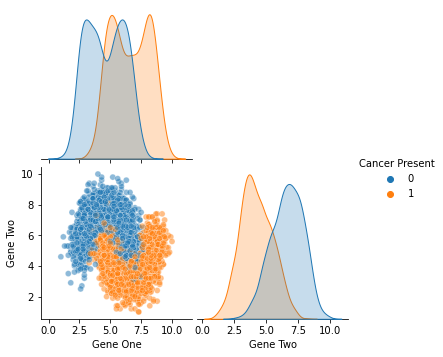

In [16]:
sns.pairplot(df, hue='Cancer Present', plot_kws={'alpha':0.5}, corner=True);

Seem like Gene One Cancer Present or not, are overlapped a lot than in Gene Two.

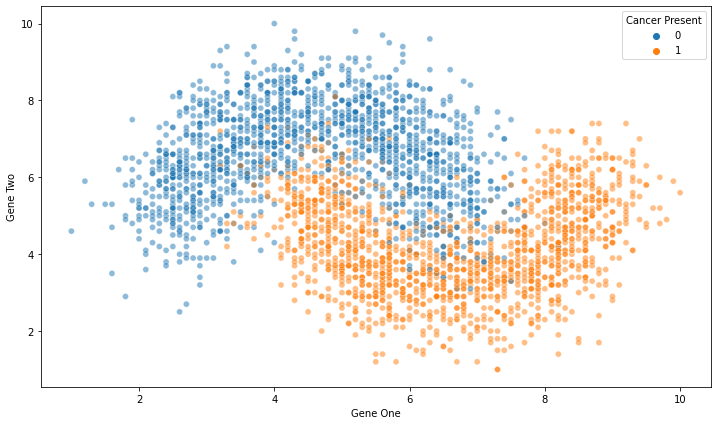

In [22]:
plt.figure(figsize=(12,7))
sns.scatterplot(data=df, x='Gene One', y='Gene Two', hue='Cancer Present', alpha=0.5);

### Zooming in specific range (section)

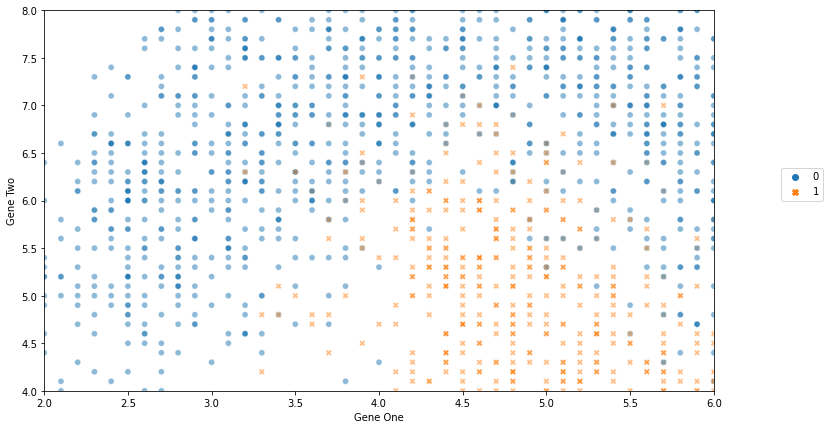

In [28]:
plt.figure(figsize=(12,7))
sns.scatterplot(data=df, x='Gene One', y='Gene Two', hue='Cancer Present', alpha=0.5, style='Cancer Present');
plt.xlim(2, 6)
plt.ylim(4, 8)
plt.legend(loc=(1.1, 0.5))

----

# Training Model

## Train|Test Split and Scaling Data

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [30]:
X = df.drop('Cancer Present', axis=1)
y = df['Cancer Present']

In [32]:
X_train, X_test,  y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [34]:
# MUST DO SCALING for KNN
scaler = StandardScaler()

scaled_X_train = scaler.fit_transform(X_train) 
scaled_X_test = scaler.transform(X_test)

In [37]:
from sklearn.neighbors import KNeighborsClassifier

In [39]:
# help(KNeighborsClassifier)

#### Simple model with neighbor 1

In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=1)

In [41]:
knn_model.fit(scaled_X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [42]:
y_pred = knn_model.predict(scaled_X_test)

In [44]:
# y_pred

## Model Evaluation

In [51]:
# Evaluating the model
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, plot_roc_curve

In [46]:
confusion_matrix(y_test, y_pred)

array([[420,  50],
       [ 47, 383]], dtype=int64)

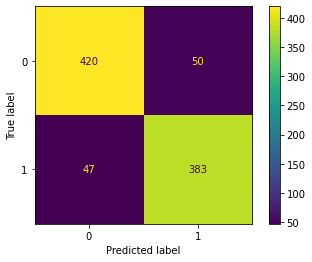

In [47]:
plot_confusion_matrix(knn_model, scaled_X_test, y_test);

In [48]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.89      0.90       470
           1       0.88      0.89      0.89       430

    accuracy                           0.89       900
   macro avg       0.89      0.89      0.89       900
weighted avg       0.89      0.89      0.89       900



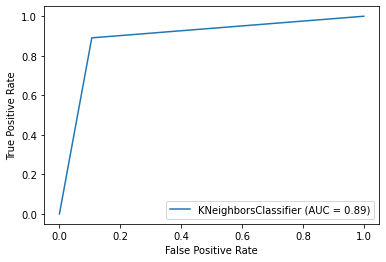

In [55]:
plot_roc_curve(knn_model, scaled_X_test, y_test);

---------

# 2 Methods for choosing K values 
- elbow method
- K fold crosss validation Grid Search method

In [56]:
from sklearn.metrics import accuracy_score

In [57]:
accuracy = accuracy_score(y_test, y_pred)

In [58]:
error = 1 - accuracy
error

0.10777777777777775

# Elbow Method for Choosing Reasonable K Values

NOTE: This uses the test set for the hyperparameter selection of K.

In [59]:
# check for K = 1 to 29 manully
test_error_rates = []

for k in range(1, 30):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(scaled_X_train, y_train)
    
    y_pred = knn_model.predict(scaled_X_test)
    error = 1 - accuracy_score(y_test, y_pred)
    test_error_rates.append(error)

In [72]:
test_error_rates[:5]

[0.10777777777777775,
 0.09999999999999998,
 0.07444444444444442,
 0.07666666666666666,
 0.07222222222222219]

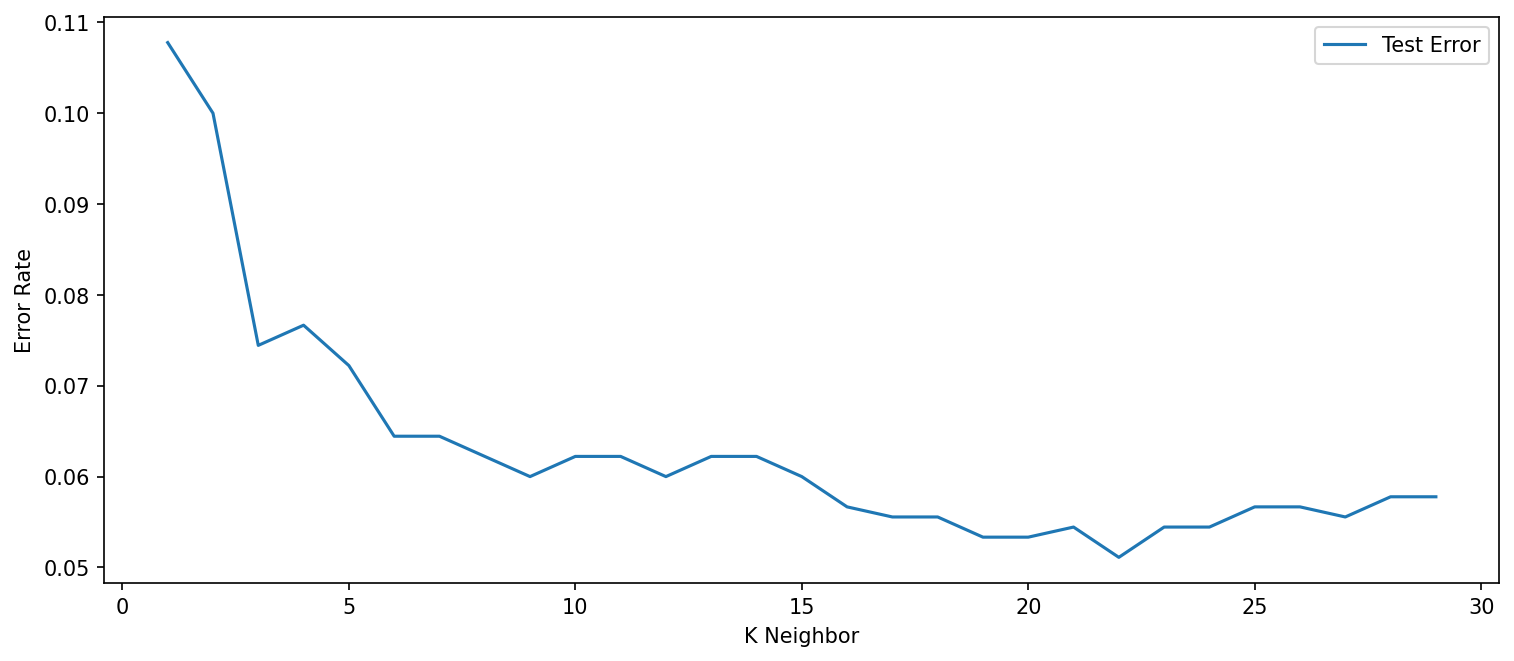

In [73]:
# ploting out
plt.figure(figsize=(12,5), dpi=150)
plt.plot(range(1, 30), test_error_rates, label='Test Error')
plt.xlabel('K Neighbor')
plt.ylabel('Error Rate')
plt.legend();

##### IMPORTANT :

Here we may be tempted to choose `K value` of lowest error rate. 
- However we need to take note that `higher K value means MORE complex model`. 
- There is no so much improvement error rate start from K value of around 8 or 9 .. all the way to the higer K value. So we need to make a call of whether chooing a K value of 16 is really worth to use, to drop an error rate of 1%.
- Although it depends to context, we need to take into consideration for all those points.

------

# Full Cross Validation Grid Search for K Value

## Creating a Pipeline to find K value

We'll use a Pipeline object to set up a workflow of operations:

- Scale Data
- Create Model on Scaled Data

Pipeline can be used for any operations with any algorithms/models.

In [74]:
# PIPELINE => GRIDSEARCH CV

#### 1) Create scaler and model that we want to use

In [ ]:
scaler = StandardScaler()

In [76]:
knn = KNeighborsClassifier()

#### 2) setting up operations
- each operation in tuple pair form
- need to pass in order of sequence we want to perform. Here want to do 1) scaling first 2) then Modeling
- always best practice to use `same string name` and `object naming` for eaiser understaing

In [83]:
operations = [('scaler', scaler), ('knn', knn)]

#### 3) setting up pipeline
- create pipeline object and pass in operations object as steps

In [84]:
from sklearn.pipeline import Pipeline

In [85]:
pipe = Pipeline(operations)

#### 4) using GridSearchCV with pipeline
- we don't really have to use pipeline for GridSearchCV
- but pipeline allows us to streamline our codes and operations

In [86]:
from sklearn.model_selection import GridSearchCV

In [88]:
# define range of k values want to setup
k_values = list(range(1, 20))

##### 4.1) Set up Parameters for pipeline
As we are using pipeline, we need to define parameters in specific format
- chosen_string_name + **two** underscores + parameter key name

Example: knn__metric: [...]

In [78]:
# we can get Parameter Key Name to use when passing into pipeline
# depends on the algorithms / models we use, these parameters needs to be aligned accordingly
# here we are just searching for KNN model
knn.get_params().keys()

dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])

In [92]:
# setup parameters
parameters = {'knn__n_neighbors': k_values}

#### 4.2) GridSearchCV
scoring options: https://scikit-learn.org/stable/modules/model_evaluation.html

In [93]:
full_cv_classifier = GridSearchCV(pipe, parameters, cv=5, scoring='accuracy')

**NOTE: we don't need to manually scale the train data. Because piepeline will take care of it as we define the scaling step as 1st step of operations.**
so we can just pass in X_train directly.

In [94]:
full_cv_classifier.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19]},
             scoring='accuracy')

In [96]:
# check the best estimator
full_cv_classifier.best_estimator_.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('knn', KNeighborsClassifier(n_neighbors=14))],
 'verbose': False,
 'scaler': StandardScaler(),
 'knn': KNeighborsClassifier(n_neighbors=14),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'knn__algorithm': 'auto',
 'knn__leaf_size': 30,
 'knn__metric': 'minkowski',
 'knn__metric_params': None,
 'knn__n_jobs': None,
 'knn__n_neighbors': 14,
 'knn__p': 2,
 'knn__weights': 'uniform'}

As from the data above, the best n_neighbors is 14.

------

**How many total runs did we do?**

In [98]:
full_cv_classifier.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_knn__n_neighbors', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [99]:
len(k_values)

19

In [100]:
full_cv_classifier.cv_results_['mean_test_score']

array([0.90238095, 0.90285714, 0.91857143, 0.91333333, 0.92380952,
       0.92142857, 0.9252381 , 0.9247619 , 0.9252381 , 0.92190476,
       0.9252381 , 0.9247619 , 0.92761905, 0.92904762, 0.92809524,
       0.92809524, 0.92904762, 0.92857143, 0.92761905])

In [101]:
len(full_cv_classifier.cv_results_['mean_test_score'])

19

-----

There are many ways that we can do for final prediction.
- retrain on full dataset with trained full_cv_classifier model
- make predicting on hold out test set with trained full_cv_classifier mode
- or create a new model with best K value that we got from GridSearchCV, retrain and make prediction

#### continue using the model for prediction

In [118]:
full_pred = full_cv_classifier.predict(X_test)

In [119]:
print(classification_report(y_test, full_pred))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       470
           1       0.95      0.92      0.93       430

    accuracy                           0.94       900
   macro avg       0.94      0.94      0.94       900
weighted avg       0.94      0.94      0.94       900



We can make the direct prediction like above or we can create a new model with best K value that we found from GridSearchCV as below.

-------

# Final Model

We just saw that our GridSearch recommends a K=14 (in line with our alternative Elbow Method). Let's now use the PipeLine again, but this time, no need to do a grid search, instead we will evaluate on our hold-out Test Set.

In [105]:
scaler = StandardScaler()
knn14 = KNeighborsClassifier(n_neighbors=14)

In [106]:
operations = [('scaler', scaler),('knn14', knn14)]

In [107]:
pipeline = Pipeline(operations)

In [108]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('knn14', KNeighborsClassifier(n_neighbors=14))])

In [110]:
pipeline_pred = pipeline.predict(X_test)

In [113]:
print(classification_report(y_test, pipeline_pred))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       470
           1       0.95      0.92      0.93       430

    accuracy                           0.94       900
   macro avg       0.94      0.94      0.94       900
weighted avg       0.94      0.94      0.94       900



In [114]:
new_patient = [[3.8, 6.4]]

In [115]:
pipeline.predict(new_patient)

array([0], dtype=int64)

In [116]:
pipeline.predict_proba(new_patient)

array([[1., 0.]])

We are pretty much sure that this new patient doesn't have cancer.